In [ ]:
# Class example on gender and related adjectives

In [7]:
import torch
torch.manual_seed(10)
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
from sklearn import decomposition
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

C:\Users\Wade\AppData\Local\Temp\ipykernel_20500\1219979266.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [1]:
corpus = ['king is a strong man',
          'queen is a wise woman',
          'boy is a young man',
          'girl is a young woman',
          'prince is a young king',
          'princess is a young queen',
          'man is strong',
          'woman is pretty',
          'prince is a boy will be king',
          'princess is a girl will be queen']

In [3]:
def create_vocab(corpus):
    vocab = {}
    i = 0
    for s in corpus:
        for word in s.split():
            if word not in vocab:
                vocab[word] = i
                i += 1
    return vocab


In [17]:
vocab = create_vocab(corpus) # test with stopwords
vocab

{'king': 0,
 'strong': 1,
 'man': 2,
 'queen': 3,
 'wise': 4,
 'woman': 5,
 'boy': 6,
 'young': 7,
 'girl': 8,
 'prince': 9,
 'princess': 10,
 'pretty': 11}

In [18]:
def prepare_set_ravel(corpus, n_gram=1):
    '''Creates a dataset with Input column and Output column for neighboring words.
       The number of neighbors = n_gram*2'''
    columns = ['Input', 'Output']
    rows = []  # List to store rows
    for sentence in corpus:
        for i, w in enumerate(sentence.split()):
            inp = w
            for n in range(1, n_gram + 1):
                # look back
                if (i - n) >= 0:
                    out = sentence.split()[i - n]
                    rows.append([inp, out])

                # look forward
                if (i + n) < len(sentence.split()):
                    out = sentence.split()[i + n]
                    rows.append([inp, out])

    # Convert list of rows to DataFrame
    result = pd.DataFrame(rows, columns=columns)
    return result

In [19]:
# prepare_set_ravel(corpus, 1)
# 'king is a strong man' example, king is, is king, is a etc...


In [20]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stops(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ". join(out))
    return result

corpus = remove_stops(corpus)
corpus

['king strong man',
 'queen wise woman',
 'boy young man',
 'girl young woman',
 'prince young king',
 'princess young queen',
 'man strong',
 'woman pretty',
 'prince boy king',
 'princess girl queen']

In [21]:
train_embs = prepare_set_ravel(corpus, 1)
train_embs.head(2)

,Input,Output
0,king,strong
1,strong,king


In [22]:
# Map the words in the "Input" and "Output" columns of the train data frame to their corresponding indices in the vocabulary
train_embs.Input = train_embs.Input.map(vocab)
train_embs.Output = train_embs.Output.map(vocab)
train_embs.head()

,Input,Output
0,0,1
1,1,0
2,1,2
3,2,1
4,3,4


In [35]:
train_embs.shape

(36, 2)

In [36]:
vocab_size = len(vocab)
# Transform 1D tensor of word indexes to one-hot encoded 2D tensor
def get_input_tensor(tensor):
    size = [*tensor.shape][0]
    # uses scatter_ to fill in ones at the positions specified by tensor.unsqueeze(1). This effectively one-hot encodes the input tensor.
    inp = torch.zeros(size, vocab_size).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

In [37]:
torch.cuda.is_available()

False

In [38]:
device = torch.device('cpu')

Recall the architecture of NN.
- W1 matrix of size vocab_size  ×  embedding_dims
- W2 of shape embedding_dims  × vocab_size.
- requires_grad = True, as we want NN to compute gradients for those weights matices for their optimization.
- Weights should be initialized to small random numbers by using function torch.randn for randomization and using uniform_ to limit bounds of weights between (−0.5/embedding_dims,  0.5/embedding_dims).

In [42]:
initdims = 5
initrange = 0.5 / initdims
W1 = Variable(torch.randn(vocab_size, initdims, device=device).uniform_(-initrange, initrange).float(), requires_grad=True)
W2 = Variable(torch.randn(initdims, vocab_size, device=device).uniform_(-initrange, initrange).float(), requires_grad=True)
print(f'W1 shape is: {W1.shape}, W2 shape is: {W2.shape}')

W1 shape is: torch.Size([12, 5]), W2 shape is: torch.Size([5, 12])


In [44]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []
for epo in range(num_epochs):
    for x,y in zip(DataLoader(train_embs.Input.values, batch_size=train_embs.shape[0]), DataLoader(train_embs.Output.values, batch_size=train_embs.shape[0])):

        # one-hot encode input tensor
        input_tensor = get_input_tensor(x) #shape N*V

        # simple NN architecture
        h = input_tensor.mm(W1) # shape 1*H
        y_pred = h.mm(W2) # shape 1*V, follows number of outputs we need

        # define loss func
        loss_f = torch.nn.CrossEntropyLoss() # details: https://pytorch.org/docs/stable/nn.html

        #compute loss
        loss = loss_f(y_pred, y)

        # backpropagation step
        loss.backward()

        # Update weights using gradient descent. For this step we just want to mutate
        # the values of w1 and w2 in-place; we don't want to build up a computational
        # graph for the update steps, so we use the torch.no_grad() context manager
        # to prevent PyTorch from building a computational graph for the updates
        # https://pytorch.org/blog/computational-graphs-constructed-in-pytorch/
        with torch.no_grad():
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data
            # zero gradients for next step
            W1.grad.data.zero_()
            W1.grad.data.zero_()
    if epo%10 == 0:
        learning_rate *= lr_decay
    loss_hist.append(loss)
    if epo%50 == 0:
        print(f'Epoch {epo}, loss = {loss}')

Epoch 0, loss = 2.4862873554229736
Epoch 50, loss = 2.2410993576049805
Epoch 100, loss = 1.32881498336792
Epoch 150, loss = 1.1530431509017944
Epoch 200, loss = 1.9528565406799316
Epoch 250, loss = 3.332357168197632
Epoch 300, loss = 2.481595277786255
Epoch 350, loss = 1.4653700590133667
Epoch 400, loss = 1.3871113061904907
Epoch 450, loss = 1.714005470275879
Epoch 500, loss = 1.459080457687378
Epoch 550, loss = 1.4917056560516357
Epoch 600, loss = 1.6490943431854248
Epoch 650, loss = 1.3645071983337402
Epoch 700, loss = 1.3953323364257812
Epoch 750, loss = 1.3684672117233276
Epoch 800, loss = 1.3324813842773438
Epoch 850, loss = 1.2841767072677612
Epoch 900, loss = 1.2464174032211304
Epoch 950, loss = 1.2127447128295898
Epoch 1000, loss = 1.1983641386032104
Epoch 1050, loss = 1.1932872533798218
Epoch 1100, loss = 1.1880725622177124
Epoch 1150, loss = 1.1822333335876465
Epoch 1200, loss = 1.176114559173584
Epoch 1250, loss = 1.1720361709594727
Epoch 1300, loss = 1.1649975776672363
Epoc

In [78]:
plotloss = list(x.item() for x in loss_hist)


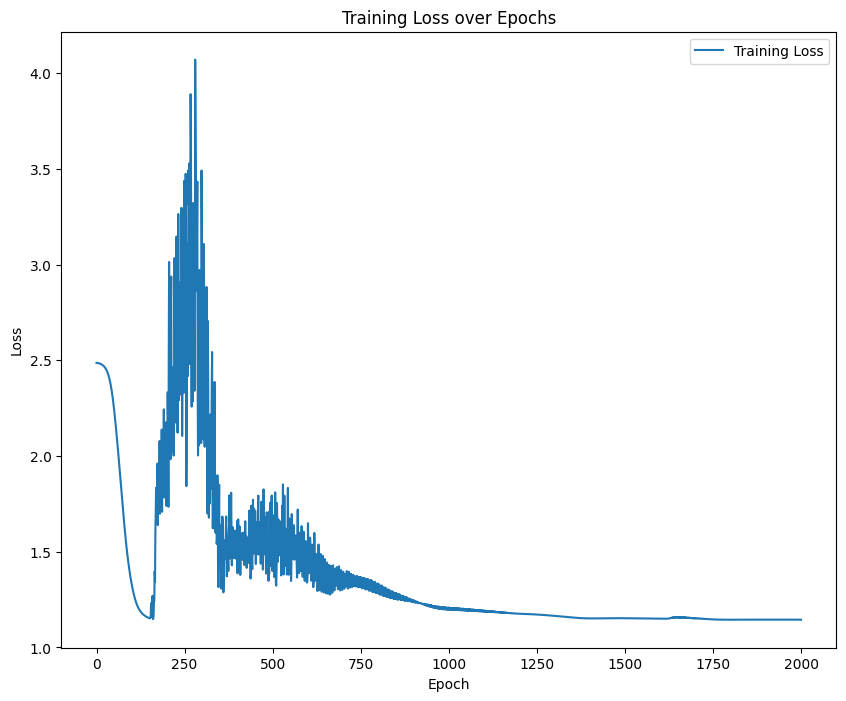

In [80]:
plt.plot(plotloss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

Fall in loss over time, the number of epochs we need should be set high enough such that we do not
end up with a model at a region that may be rising in error.

In [82]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()
W1

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [ ]:
W1.shape

(12, 5)

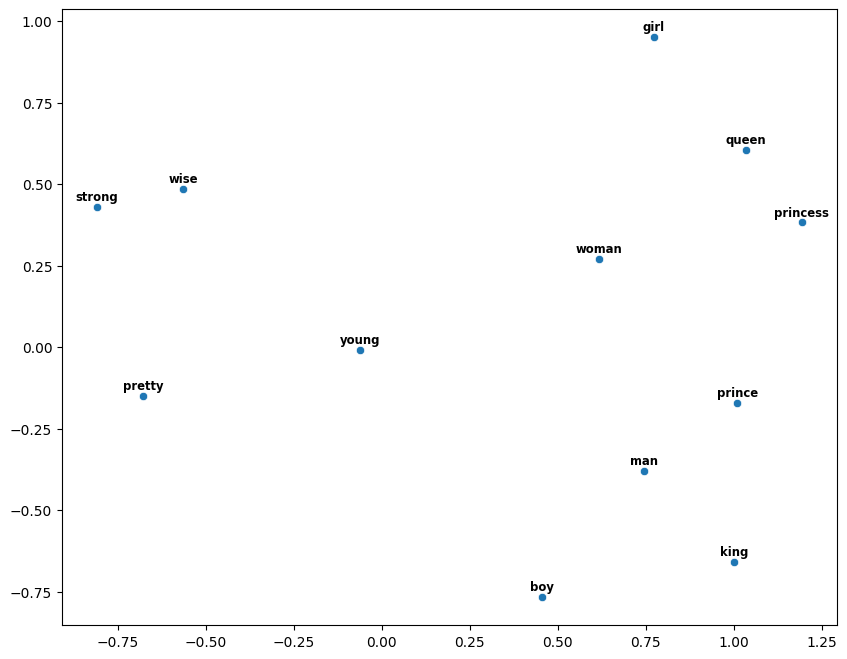

In [ ]:
svd = decomposition.TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:,0]
y = W1_dec[:,1]
plot = sns.scatterplot(x=x, y=y)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocab.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold')

We can clearly identify groups and patterns. Masculine adjectives, female nouns, male nouns are grouped
closer together.